# Primeira seção de modelos

Somente as variáveis originais, com IV até 0.5 e não correlacionadas

# Pacotes e funções

In [1]:
import pandas as pd 
import numpy as np
import mlflow
from mlflow.models import infer_signature
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score, average_precision_score, brier_score_loss, confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_recall_curve, log_loss
from sklearn.model_selection import cross_val_score, StratifiedKFold
import xgboost
from catboost import CatBoostClassifier
import lightgbm
from hyperopt import fmin, tpe, Trials, hp
from functools import partial
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [8]:
#!pip install xgboost
#!pip install catboost
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension
#!pip install hyperopt
#!pip install lightgbm

# Bases pré-processadas

In [2]:
treino_full = pd.read_parquet('../3.Pre_processamento/treino_pp.parquet')
val_full = pd.read_parquet('../3.Pre_processamento/validacao_pp.parquet')

In [3]:
treino_full.shape

(783000, 16)

In [3]:
# Fase amostral: 10% da base de treino
treino = treino_full.sample(frac=.1, random_state=123)

In [5]:
treino.shape

(78300, 16)

In [6]:
treino['fraud'].value_counts()/treino.shape[0]

fraud
0    0.91424
1    0.08576
Name: count, dtype: float64

In [7]:
np.log(0.08576/0.91424)

-2.3665404217199164

In [8]:
treino.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud,RROO,RRUC,log_DFH,log_DFLT,log_RTMPP,log_DFH_padro,log_DFLT_padro,log_RTMPP_padro
275847,3.132982,0.136709,0.905399,1,0,0,1,0,1,0,1.141985,-1.989898,-0.099380,-0.826670,-1.104029,-0.089090
287479,20.395077,0.805684,2.582759,1,0,1,1,0,1,0,3.015294,-0.216063,0.948858,0.510707,-0.118208,0.865273
737603,55.317530,2.933958,0.573614,1,0,0,1,0,1,0,4.013090,1.076352,-0.555799,1.223046,0.600060,-0.504634
136843,378.405321,1.208453,2.182680,1,0,0,1,1,1,0,5.935966,0.189341,0.780553,2.595811,0.107098,0.712041
313895,9.967356,1.027505,0.781084,1,0,0,1,0,1,0,2.299315,0.027133,-0.247073,-0.000438,0.016950,-0.223556


In [ ]:
colunas = ['repeat_retailer','used_chip','used_pin_number','online_order','log_DFH_padro','log_DFLT_padro']

X_treino = treino[colunas]
y_treino = treino['fraud']

X_val = val_full[colunas]
y_val = val_full['fraud']

In [10]:
y_treino.sum()/len(y_treino), y_val.sum()/len(y_val)

(0.08575989782886334, 0.0874017094017094)

# Criação do experimento

In [ ]:
#experiment = mlflow.create_experiment(name = 'Modelos',
#                                      artifact_location = 'Artf_Modelos',
#                                      tags = {'Environment': 'Development', 'Version': '1.0.0'})

In [ ]:
#experiment

'189457669412080989'

In [5]:
experiment = mlflow.set_experiment(experiment_id = '189457669412080989')
experiment.experiment_id

'189457669412080989'

# Modelos

## Regressão logística

In [21]:
# https://bookdown.org/egarpor/PM-UC3M/glm-deviance.html
# https://stats.stackexchange.com/questions/108995/interpreting-residual-and-null-deviance-in-glm-r

LR = sm.GLM(y_treino, sm.add_constant(X_treino), family=sm.families.Binomial())
LR_results = LR.fit()

In [22]:
LR_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  fraud   No. Observations:                78300
Model:                            GLM   Df Residuals:                    78293
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19206.
Date:                Thu, 03 Apr 2025   Deviance:                       38413.
Time:                        20:30:34   Pearson chi2:                 7.11e+04
No. Iterations:                     9   Pseudo R-squ. (CS):            0.09031
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.8151      0.068    -41.415      0.000      -2.948      -2.682
repeat_retailer    -1.5955      0.054    -29.725      0.000      -1.701      -1.490
used_chip          -0.5194      0.030    -17.221      0.000      -0.579      -0.460
used_pin_number    -3.6776      0.210    -17.543      0.000      -4.089      -3.267
online_order        2.4200      0.054     44.405      0.000       2.313       2.527
log_DFH_padro       0.7188      0.017     43.251      0.000       0.686       0.751
log_DFLT_padro      0.2127      0.013     15.791      0.000       0.186       0.239
===================================================================================
"""

In [23]:
LR_results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Generalized linear model
=================================================================
Model:              GLM              AIC:            38426.7592  
Link Function:      Logit            BIC:            -843816.4784
Dependent Variable: fraud            Log-Likelihood: -19206.     
Date:               2025-04-03 20:30 LL-Null:        -22912.     
No. Observations:   78300            Deviance:       38413.      
Df Model:           6                Pearson chi2:   7.11e+04    
Df Residuals:       78293            Scale:          1.0000      
Method:             IRLS                                         
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const            -2.8151   0.0680 -41.4152 0.0000 -2.9484 -2.6819
repeat_retailer  -1.5955   0.0537 -29.7254 0.0000 -1.7007 -1.4903
used_chip        -0.5194   0.0302 -17.2214 0.0000 -0.5785 -0.4603
used_pin_number  -3.6776   0.2096 -17.5432 0.0000 -4.0885 -3.2668
online_order      2.4200   0.0545  44.4046 0.0000  2.3132  2.5268
log_DFH_padro     0.7188   0.0166  43.2508 0.0000  0.6862  0.7514
log_DFLT_padro    0.2127   0.0135  15.7911 0.0000  0.1863  0.2391
=================================================================

"""

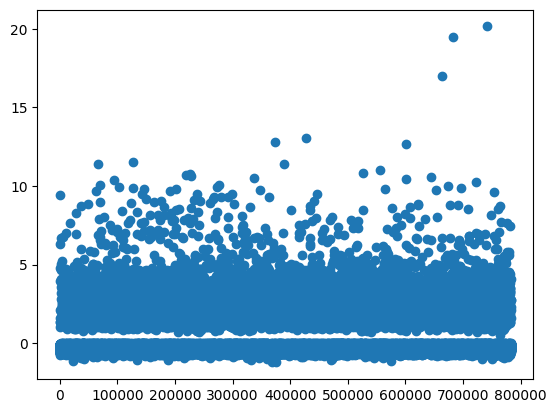

In [24]:
# O eixo x é o índice da observação e o eixo y é o resíduo de pearson
plt.plot(LR_results.resid_pearson, 'o', ls='None')
plt.show()

In [27]:
if __name__ == '__main__':
    
    with mlflow.start_run(run_name = 'LR_Sample_VarOrig', experiment_id = experiment.experiment_id) as run: 
        
        signature = infer_signature(X_treino, LR_results.predict(sm.add_constant(X_treino)))
        mlflow.statsmodels.log_model(LR_results, signature=signature, artifact_path='modelo')
        
        mlflow.log_params(LR_results.params)

        # Log das métricas na base de TREINO
        mlflow.log_metric('AUC_PR_Treino', average_precision_score(y_treino, LR_results.predict(sm.add_constant(X_treino))))
        mlflow.log_metric('AUC_ROC_Treino', roc_auc_score(y_treino, LR_results.predict(sm.add_constant(X_treino))))
        mlflow.log_metric('BS_Treino', brier_score_loss(y_treino, LR_results.predict(sm.add_constant(X_treino))))
        mlflow.log_metric('Log_Loss_Treino', log_loss(y_treino, LR_results.predict(sm.add_constant(X_treino)), normalize=True))

        # Log das métricas na base de VALIDAÇÃO
        mlflow.log_metric('AUC_PR_Val', average_precision_score(y_val, LR_results.predict(sm.add_constant(X_val))))
        mlflow.log_metric('AUC_ROC_Val', roc_auc_score(y_val, LR_results.predict(sm.add_constant(X_val))))
        mlflow.log_metric('BS_Val', brier_score_loss(y_val, LR_results.predict(sm.add_constant(X_val))))
        mlflow.log_metric('Log_Loss_Val', log_loss(y_val, LR_results.predict(sm.add_constant(X_val)), normalize=True))

/home/hugo/Documents/Git_GitHub/Estudo_Fraude_CC/vFraude_CC/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


## Função objetivo

Função objetivo para ser minimizada e encontrar o melhor conjunto de hiperparâmetros com o uso de validação cruzada.

In [21]:
def func_objetivo_CV(parametros, modelo, folds, expr, X, y):
    # função objetivo para "minimizar", mas dependendo da métrica de interesse, na realidade, é maximizar 
    # parametros é o espaço paramétrico a ser explorado
    # expr é uma string que representa o id do experimento que foi criado
    # modelo é uma string de qual modelo será rodado: Random Forest ou XGBoost
    # folds é um int que diz quantos folds de validação serão usados
    # X e y são as bases que serão aplicadas o cross-validation

    # O output é o valor do score a ser minimizado/maximizado
    
    with mlflow.start_run(nested = True, experiment_id=expr) as run:

        SKF = StratifiedKFold(n_splits = folds, shuffle=True, random_state=1234)

        if modelo == 'RF':
            clf = RandomForestClassifier(**parametros) 
            clf.fit(X, y)
        elif modelo == 'XGB':
            clf = xgboost.XGBClassifier(**parametros)
            clf.fit(X, y)
        elif modelo == 'CAT':
            clf = CatBoostClassifier(**parametros, verbose=False, cat_features = ['used_chip', 'repeat_retailer', 'used_pin_number', 'online_order'], loss_function = 'Logloss')
            clf.fit(X, y)
        elif modelo == 'LGBM':
            clf = lightgbm.LGBMClassifier(**parametros, verbose=-1)
            clf.fit(X, y)
        
        score = cross_val_score(estimator = clf, X = X, y = y, cv = SKF, scoring='neg_log_loss').mean()

        # Log de parâmetros e métricas

        mlflow.log_params(clf.get_params())
        mlflow.log_metric('average_precision_cv', cross_val_score(estimator = clf, X = X, y = y, cv = SKF, scoring='average_precision').mean())
        mlflow.log_metric('roc_auc_cv', cross_val_score(estimator = clf, X = X, y = y, cv = SKF, scoring='roc_auc').mean())
        mlflow.log_metric('neg_brier_score_cv', cross_val_score(estimator = clf, X = X, y = y, cv = SKF, scoring='neg_brier_score').mean())
        mlflow.log_metric('neg_log_loss_cv', cross_val_score(estimator = clf, X = X, y = y, cv = SKF, scoring='neg_log_loss').mean())
        
        signature = infer_signature(X, clf.predict_proba(X))
        mlflow.sklearn.log_model(clf, signature=signature, artifact_path='modelo')

    return -score

## Random Forest

In [29]:
# Sem tunning de hiperparâmetros

if __name__ == '__main__':
    
    with mlflow.start_run(run_name = 'RF_Sample_VarOrig', experiment_id = experiment.experiment_id) as run: 

        rf = RandomForestClassifier()
        rf.fit(X_treino, y_treino)

        # Log dos parâmetros do modelo
        mlflow.log_params(rf.get_params())

        # Log das métricas na base de TREINO
        mlflow.log_metric('AUC_PR_Treino', average_precision_score(y_treino, rf.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('AUC_ROC_Treino', roc_auc_score(y_treino, rf.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('BS_Treino', brier_score_loss(y_treino, rf.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('Log_Loss_Treino', log_loss(y_treino, rf.predict_proba(X_treino)[:,1], normalize=True))

        # OBS: o ponto de corte utilizado é o 0.5 (ainda não otimizamos esse ponto)
        #mlflow.log_metric('F1_Treino', f1_score(y_treino, rf.predict(X_treino)))
        #mlflow.log_metric('Precision_Treino', precision_score(y_treino, rf.predict(X_treino)))
        #mlflow.log_metric('Recall_Treino', recall_score(y_treino, rf.predict(X_treino)))
        #mlflow.log_metric('Acuracia_Treino', accuracy_score(y_treino, rf.predict(X_treino)))

        # Log das métricas na base de VALIDAÇÃO
        mlflow.log_metric('AUC_PR_Val', average_precision_score(y_val, rf.predict_proba(X_val)[:,1]))
        mlflow.log_metric('AUC_ROC_Val', roc_auc_score(y_val, rf.predict_proba(X_val)[:,1]))
        mlflow.log_metric('BS_Val', brier_score_loss(y_val, rf.predict_proba(X_val)[:,1]))
        mlflow.log_metric('Log_Loss_Val', log_loss(y_val, rf.predict_proba(X_val)[:,1], normalize=True))

        # OBS: o ponto de corte utilizado é o 0.5 (ainda não otimizamos esse ponto)
        #mlflow.log_metric('F1_Val', f1_score(y_val, rf.predict(X_val)))
        #mlflow.log_metric('Precision_Val', precision_score(y_val, rf.predict(X_val)))
        #mlflow.log_metric('Recall_Val', recall_score(y_val, rf.predict(X_val)))
        #mlflow.log_metric('Acuracia_Val', accuracy_score(y_val, rf.predict(X_val)))
        
        # Log do schema das variáveis do modelo e do modelo
        signature = infer_signature(X_treino, rf.predict_proba(X_treino))
        mlflow.sklearn.log_model(rf, signature=signature, artifact_path='modelo')

/home/hugo/Documents/Git_GitHub/Estudo_Fraude_CC/vFraude_CC/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [30]:
# Com tunning de hiperparâmetros

if __name__ == '__main__':
    
    #test_imbalanced = [{0: len(y_treino2)/(2*np.bincount(y_treino2))[0], 1:len(y_teste2)/(2*np.bincount(y_teste2))[1]}, {0: 1, 1:1}]
    
    space = {
        "n_estimators": hp.choice('n_estimators', np.arange(10, 100, dtype=int)),
        "max_depth": hp.choice('max_depth', np.arange(10, 50, dtype=int)),
        "min_samples_leaf": hp.choice('min_samples_leaf', np.arange(100, 500, dtype=int)),
        "min_samples_split": hp.choice('min_samples_split', np.arange(100, 500, dtype=int)),
        "criterion": hp.choice("criterion", ['gini', 'entropy', 'log_loss']),
        "class_weight": hp.choice("class_weight", ['balanced', 'balanced_subsample', None]),
        "max_features": hp.uniform("max_features", 0.1, 1),
        "max_samples": hp.uniform("max_samples", 0.1, 1)
    }
    
    with mlflow.start_run(run_name = 'RF_Sample_VarOrig_CV', experiment_id=experiment.experiment_id) as run:
        best_params = fmin(
            fn = partial(
                func_objetivo_CV,
                expr = experiment.experiment_id,
                modelo = 'RF',
                X = X_treino,
                y = y_treino,
                folds = 5
            ),
            space = space,
            algo = tpe.suggest,
            max_evals = 25,
            trials = Trials(),
            timeout = 10
        )

        if best_params['criterion'] == 0:
            best_params['criterion'] = 'gini'
        elif best_params['criterion'] == 1:
            best_params['criterion'] = 'entropy'
        else:
            best_params['criterion'] = 'log_loss'
            

        if best_params['class_weight'] == 0:
            best_params['class_weight'] = 'balanced'
        elif best_params['class_weight'] == 1:
            best_params['class_weight'] = 'balanced_subsample'
        else:
            best_params['class_weight'] = None
        
        # Identificado o melhor conjunto de hiperparâmetros, treina o modelo com toda a base de treino e metrifica os escores na base de validação

        clf = RandomForestClassifier(**best_params)
        clf.fit(X_treino, y_treino)
                   
        mlflow.log_params(clf.get_params())
        mlflow.log_metric('AUC_PR_Val', average_precision_score(y_val, clf.predict_proba(X_val)[:,1]))
        mlflow.log_metric('Log_Loss_Val', log_loss(y_val, clf.predict_proba(X_val)[:,1], normalize=True))
        mlflow.log_metric('AUC_ROC_Val', roc_auc_score(y_val, clf.predict_proba(X_val)[:,1]))
        mlflow.log_metric('BS_Val', brier_score_loss(y_val, clf.predict_proba(X_val)[:,1]))

        # Log das métricas na base de TREINO
        mlflow.log_metric('AUC_PR_Treino', average_precision_score(y_treino, clf.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('AUC_ROC_Treino', roc_auc_score(y_treino, clf.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('BS_Treino', brier_score_loss(y_treino, clf.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('Log_Loss_Treino', log_loss(y_treino, clf.predict_proba(X_treino)[:,1], normalize=True))

        signature = infer_signature(X_treino, clf.predict_proba(X_treino))
        mlflow.sklearn.log_model(clf, signature=signature, artifact_path='modelo')

  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

/home/hugo/Documents/Git_GitHub/Estudo_Fraude_CC/vFraude_CC/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



  4%|▍         | 1/25 [02:49<1:07:53, 169.72s/trial, best loss: 0.22111663760854552]


/home/hugo/Documents/Git_GitHub/Estudo_Fraude_CC/vFraude_CC/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


## XGBoost

In [31]:
# Sem tunning de hiperparâmetros

if __name__ == '__main__':
    
    with mlflow.start_run(run_name = 'XGB_Sample_VarOrig', experiment_id = experiment.experiment_id) as run: 

        XGB = xgboost.XGBClassifier()
        XGB.fit(X_treino, y_treino)

        # Log dos parâmetros do modelo
        mlflow.log_params(XGB.get_params())

        # Log das métricas na base de TREINO
        mlflow.log_metric('AUC_PR_Treino', average_precision_score(y_treino, XGB.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('AUC_ROC_Treino', roc_auc_score(y_treino, XGB.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('BS_Treino', brier_score_loss(y_treino, XGB.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('Log_Loss_Treino', log_loss(y_treino, XGB.predict_proba(X_treino)[:,1], normalize=True))

        # Log das métricas na base de VALIDAÇÃO
        mlflow.log_metric('AUC_PR_Val', average_precision_score(y_val, XGB.predict_proba(X_val)[:,1]))
        mlflow.log_metric('AUC_ROC_Val', roc_auc_score(y_val, XGB.predict_proba(X_val)[:,1]))
        mlflow.log_metric('BS_Val', brier_score_loss(y_val, XGB.predict_proba(X_val)[:,1]))
        mlflow.log_metric('Log_Loss_Val', log_loss(y_val, XGB.predict_proba(X_val)[:,1], normalize=True))

       
        # Log do schema das variáveis do modelo e do modelo
        signature = infer_signature(X_treino, XGB.predict_proba(X_treino))
        mlflow.sklearn.log_model(XGB, signature=signature, artifact_path='modelo')

/home/hugo/Documents/Git_GitHub/Estudo_Fraude_CC/vFraude_CC/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [32]:
# Com tunning de hiperparâmetros

if __name__ == '__main__':
    
    space = {
        "n_estimators": hp.choice('n_estimators', np.arange(10, 150, dtype=int)),
        "max_depth": hp.choice('max_depth', np.arange(10, 150, dtype=int)),
        "min_child_weight": hp.choice('min_child_weight', np.arange(100, 500, dtype=int)),
        "colsample_bytree": hp.quniform('colsample_bytree', 0.2, 1, 0.05),
        "colsample_bylevel": hp.quniform('colsample_bylevel', 0.2, 1, 0.05),
        "subsample": hp.quniform('subsample', 0.2, 1, 0.05),
        "colsample_bynode": hp.quniform('colsample_bynode', 0.2, 1, 0.05),
        "base_score": hp.quniform('base_score', 0.1, 1, 0.05),
        "learning_rate": hp.quniform('learning_rate', 0.0025, 0.5, 0.025),
        "gamma": hp.choice('gamma', np.arange(1, 20, dtype=int)),
        "lambda": hp.choice('lambda', np.arange(1, 20, dtype=int)),
        "alpha": hp.choice('alpha', np.arange(1, 20, dtype=int)),

    }
    
    with mlflow.start_run(run_name = 'XGB_Sample_VarOrig_CV', experiment_id=experiment.experiment_id) as run:
        best_params = fmin(
            fn = partial(
                func_objetivo_CV,
                expr = experiment.experiment_id,
                modelo = 'XGB',
                X = X_treino,
                y = y_treino,
                folds = 5
            ),
            space = space,
            algo = tpe.suggest,
            max_evals = 25,
            trials = Trials(),
            timeout = 10
        )
        
        # Identificado o melhor conjunto de hiperparâmetros, treina o modelo com toda a base de treino e metrifica os escores na base de validação

        clf = xgboost.XGBClassifier(**best_params)
        clf.fit(X_treino, y_treino)
                   
        mlflow.log_params(clf.get_params())
        mlflow.log_metric('AUC_PR_Val', average_precision_score(y_val, clf.predict_proba(X_val)[:,1]))
        mlflow.log_metric('Log_Loss_Val', log_loss(y_val, clf.predict_proba(X_val)[:,1], normalize=True))
        mlflow.log_metric('AUC_ROC_Val', roc_auc_score(y_val, clf.predict_proba(X_val)[:,1]))
        mlflow.log_metric('BS_Val', brier_score_loss(y_val, clf.predict_proba(X_val)[:,1]))

        # Log das métricas na base de TREINO
        mlflow.log_metric('AUC_PR_Treino', average_precision_score(y_treino, clf.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('AUC_ROC_Treino', roc_auc_score(y_treino, clf.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('BS_Treino', brier_score_loss(y_treino, clf.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('Log_Loss_Treino', log_loss(y_treino, clf.predict_proba(X_treino)[:,1], normalize=True))

        signature = infer_signature(X_treino, clf.predict_proba(X_treino))
        mlflow.sklearn.log_model(clf, signature=signature, artifact_path='modelo')

  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

/home/hugo/Documents/Git_GitHub/Estudo_Fraude_CC/vFraude_CC/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



  4%|▍         | 1/25 [00:10<04:14, 10.59s/trial, best loss: 0.2380938543058627]


/home/hugo/Documents/Git_GitHub/Estudo_Fraude_CC/vFraude_CC/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


## LightGBM

In [13]:
# Sem tunning de hiperparâmetros

if __name__ == '__main__':
    
    with mlflow.start_run(run_name = 'LGBM_Sample_VarOrig', experiment_id = experiment.experiment_id) as run: 

        LGBM = lightgbm.LGBMClassifier()
        LGBM.fit(X_treino, y_treino)

        # Log dos parâmetros do modelo
        mlflow.log_params(LGBM.get_params())

        # Log das métricas na base de TREINO
        mlflow.log_metric('AUC_PR_Treino', average_precision_score(y_treino, LGBM.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('AUC_ROC_Treino', roc_auc_score(y_treino, LGBM.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('BS_Treino', brier_score_loss(y_treino, LGBM.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('Log_Loss_Treino', log_loss(y_treino, LGBM.predict_proba(X_treino)[:,1], normalize=True))

        # Log das métricas na base de VALIDAÇÃO
        mlflow.log_metric('AUC_PR_Val', average_precision_score(y_val, LGBM.predict_proba(X_val)[:,1]))
        mlflow.log_metric('AUC_ROC_Val', roc_auc_score(y_val, LGBM.predict_proba(X_val)[:,1]))
        mlflow.log_metric('BS_Val', brier_score_loss(y_val, LGBM.predict_proba(X_val)[:,1]))
        mlflow.log_metric('Log_Loss_Val', log_loss(y_val, LGBM.predict_proba(X_val)[:,1], normalize=True))

       
        # Log do schema das variáveis do modelo e do modelo
        signature = infer_signature(X_treino, LGBM.predict_proba(X_treino))
        mlflow.sklearn.log_model(LGBM, signature=signature, artifact_path='modelo')

[LightGBM] [Info] Number of positive: 6715, number of negative: 71585
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 518
[LightGBM] [Info] Number of data points in the train set: 78300, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085760 -> initscore=-2.366542
[LightGBM] [Info] Start training from score -2.366542


/home/hugo/Documents/Git_GitHub/Estudo_Fraude_CC/vFraude_CC/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [7]:
# Com tunning de hiperparâmetros

if __name__ == '__main__':
    
    space = {
        "n_estimators": hp.choice('n_estimators', np.arange(10, 150, dtype=int)), 
        "max_depth": hp.choice('max_depth', np.arange(10, 50, dtype=int)), 
        "min_child_weight": hp.choice('min_child_weight', np.arange(100, 500, dtype=int)),
        "colsample_bytree": hp.quniform('colsample_bytree', 0.2, 1, 0.05),
        "subsample": hp.quniform('subsample', 0.2, 1, 0.05), 
        "colsample_bytree": hp.quniform('colsample_bynode', 0.2, 1, 0.05),
        "learning_rate": hp.quniform('learning_rate', 0.0025, 0.5, 0.025), 
        "reg_lambda": hp.choice('reg_lambda', np.arange(1, 20, dtype=float)),
        "reg_alpha": hp.choice('reg_alpha', np.arange(1, 20, dtype=float))

    }
    
    with mlflow.start_run(run_name = 'LGBM_Sample_VarOrig_CV', experiment_id=experiment.experiment_id) as run:
        best_params = fmin(
            fn = partial(
                func_objetivo_CV,
                expr = experiment.experiment_id,
                modelo = 'LGBM',
                X = X_treino,
                y = y_treino,
                folds = 5
            ),
            space = space,
            algo = tpe.suggest,
            max_evals = 25,
            trials = Trials(),
            timeout = 10
        )
        
        # Identificado o melhor conjunto de hiperparâmetros, treina o modelo com toda a base de treino e metrifica os escores na base de validação

        clf = lightgbm.LGBMClassifier(**best_params)
        clf.fit(X_treino, y_treino)
                   
        mlflow.log_params(clf.get_params())
        mlflow.log_metric('AUC_PR_Val', average_precision_score(y_val, clf.predict_proba(X_val)[:,1]))
        mlflow.log_metric('Log_Loss_Val', log_loss(y_val, clf.predict_proba(X_val)[:,1], normalize=True))
        mlflow.log_metric('AUC_ROC_Val', roc_auc_score(y_val, clf.predict_proba(X_val)[:,1]))
        mlflow.log_metric('BS_Val', brier_score_loss(y_val, clf.predict_proba(X_val)[:,1]))

        # Log das métricas na base de TREINO
        mlflow.log_metric('AUC_PR_Treino', average_precision_score(y_treino, clf.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('AUC_ROC_Treino', roc_auc_score(y_treino, clf.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('BS_Treino', brier_score_loss(y_treino, clf.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('Log_Loss_Treino', log_loss(y_treino, clf.predict_proba(X_treino)[:,1], normalize=True))

        signature = infer_signature(X_treino, clf.predict_proba(X_treino))
        mlflow.sklearn.log_model(clf, signature=signature, artifact_path='modelo')

  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

/home/hugo/Documents/Git_GitHub/Estudo_Fraude_CC/vFraude_CC/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



  4%|▍         | 1/25 [00:11<04:39, 11.67s/trial, best loss: 0.23437232394792673]


/home/hugo/Documents/Git_GitHub/Estudo_Fraude_CC/vFraude_CC/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


## Catboost

In [9]:
X_treino.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78300 entries, 275847 to 461305
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   repeat_retailer  78300 non-null  int64  
 1   used_chip        78300 non-null  int64  
 2   used_pin_number  78300 non-null  int64  
 3   online_order     78300 non-null  int64  
 4   log_DFH_padro    78300 non-null  float64
 5   log_DFLT_padro   78300 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 4.2 MB


In [10]:
X_treino['online_order'] = X_treino['online_order'].astype('category')
X_treino['repeat_retailer'] = X_treino['repeat_retailer'].astype('category')
X_treino['used_chip'] = X_treino['used_chip'].astype('category') 
X_treino['used_pin_number'] = X_treino['used_pin_number'].astype('category') 
X_treino['online_order'] = X_treino['online_order'].astype('category') 

/tmp/ipykernel_6124/3123617854.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_treino['online_order'] = X_treino['online_order'].astype('category')
/tmp/ipykernel_6124/3123617854.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_treino['repeat_retailer'] = X_treino['repeat_retailer'].astype('category')
/tmp/ipykernel_6124/3123617854.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [32]:
X_val['online_order'] = X_val['online_order'].astype('category')
X_val['repeat_retailer'] = X_val['repeat_retailer'].astype('category')
X_val['used_chip'] = X_val['used_chip'].astype('category') 
X_val['used_pin_number'] = X_val['used_pin_number'].astype('category') 
X_val['online_order'] = X_val['online_order'].astype('category') 

/tmp/ipykernel_6124/1764177593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['online_order'] = X_val['online_order'].astype('category')
/tmp/ipykernel_6124/1764177593.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['repeat_retailer'] = X_val['repeat_retailer'].astype('category')
/tmp/ipykernel_6124/1764177593.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [11]:
X_treino.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78300 entries, 275847 to 461305
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   repeat_retailer  78300 non-null  category
 1   used_chip        78300 non-null  category
 2   used_pin_number  78300 non-null  category
 3   online_order     78300 non-null  category
 4   log_DFH_padro    78300 non-null  float64 
 5   log_DFLT_padro   78300 non-null  float64 
dtypes: category(4), float64(2)
memory usage: 2.1 MB


In [23]:
# Sem tunning de hiperparâmetros

if __name__ == '__main__':
    
    with mlflow.start_run(run_name = 'CAT_Sample_VarOrig', experiment_id = experiment.experiment_id) as run: 

        CAT = CatBoostClassifier(cat_features = ['used_chip', 'repeat_retailer', 'used_pin_number', 'online_order'], loss_function = 'Logloss')
        CAT.fit(X_treino, y_treino, plot =True, verbose=False)

        # Log dos parâmetros do modelo
        mlflow.log_params(CAT.get_params())

        # Log das métricas na base de TREINO
        mlflow.log_metric('AUC_PR_Treino', average_precision_score(y_treino, CAT.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('AUC_ROC_Treino', roc_auc_score(y_treino, CAT.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('BS_Treino', brier_score_loss(y_treino, CAT.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('Log_Loss_Treino', log_loss(y_treino, CAT.predict_proba(X_treino)[:,1], normalize=True))

        # Log das métricas na base de VALIDAÇÃO
        mlflow.log_metric('AUC_PR_Val', average_precision_score(y_val, CAT.predict_proba(X_val)[:,1]))
        mlflow.log_metric('AUC_ROC_Val', roc_auc_score(y_val, CAT.predict_proba(X_val)[:,1]))
        mlflow.log_metric('BS_Val', brier_score_loss(y_val, CAT.predict_proba(X_val)[:,1]))
        mlflow.log_metric('Log_Loss_Val', log_loss(y_val, CAT.predict_proba(X_val)[:,1], normalize=True))

       
        # Log do schema das variáveis do modelo e do modelo
        signature = infer_signature(X_treino, CAT.predict_proba(X_treino))
        mlflow.sklearn.log_model(CAT, signature=signature, artifact_path='modelo')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

/home/hugo/Documents/Git_GitHub/Estudo_Fraude_CC/vFraude_CC/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [29]:
CAT.best_score_

{'learn': {'Logloss': 0.18728095784193408}}

In [30]:
CAT.feature_importances_

array([ 3.65405941, 12.76631357, 14.27424287, 44.4786923 , 18.57629549,
        6.25039637])

In [33]:
# Com tunning de hiperparâmetros
# https://www.kaggle.com/code/ezzaldin6/bayesian-search-with-catboost
# https://www.kaggle.com/code/lucamassaron/tutorial-bayesian-optimization-with-catboost

if __name__ == '__main__':
    
    space = {
        'learning_rate': hp.uniform('learning_rate', 0.1, 0.5),
        'iterations': hp.randint('iterations',100,1000),
        'l2_leaf_reg': hp.randint('l2_leaf_reg',1,10),
        'depth': hp.randint('depth',4,10)

    }
    
    with mlflow.start_run(run_name = 'CAT_Sample_VarOrig_CV', experiment_id=experiment.experiment_id) as run:
        best_params = fmin(
            fn = partial(
                func_objetivo_CV,
                expr = experiment.experiment_id,
                modelo = 'CAT',
                X = X_treino,
                y = y_treino,
                folds = 5
            ),
            space = space,
            algo = tpe.suggest,
            max_evals = 25,
            trials = Trials(),
            timeout = 10
        )
        
        # Identificado o melhor conjunto de hiperparâmetros, treina o modelo com toda a base de treino e metrifica os escores na base de validação

        clf = CatBoostClassifier(**best_params, verbose=False, cat_features = ['used_chip', 'repeat_retailer', 'used_pin_number', 'online_order'], loss_function = 'Logloss')
        clf.fit(X_treino, y_treino)
                   
        mlflow.log_params(clf.get_params())
        mlflow.log_metric('AUC_PR_Val', average_precision_score(y_val, clf.predict_proba(X_val)[:,1]))
        mlflow.log_metric('Log_Loss_Val', log_loss(y_val, clf.predict_proba(X_val)[:,1], normalize=True))
        mlflow.log_metric('AUC_ROC_Val', roc_auc_score(y_val, clf.predict_proba(X_val)[:,1]))
        mlflow.log_metric('BS_Val', brier_score_loss(y_val, clf.predict_proba(X_val)[:,1]))

        # Log das métricas na base de TREINO
        mlflow.log_metric('AUC_PR_Treino', average_precision_score(y_treino, clf.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('AUC_ROC_Treino', roc_auc_score(y_treino, clf.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('BS_Treino', brier_score_loss(y_treino, clf.predict_proba(X_treino)[:,1]))
        mlflow.log_metric('Log_Loss_Treino', log_loss(y_treino, clf.predict_proba(X_treino)[:,1], normalize=True))

        signature = infer_signature(X_treino, clf.predict_proba(X_treino))
        mlflow.sklearn.log_model(clf, signature=signature, artifact_path='modelo')

  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

/home/hugo/Documents/Git_GitHub/Estudo_Fraude_CC/vFraude_CC/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



  4%|▍         | 1/25 [06:04<2:25:54, 364.76s/trial, best loss: 0.22088445675328425]


/home/hugo/Documents/Git_GitHub/Estudo_Fraude_CC/vFraude_CC/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


## Isolation Forest 

In [ ]:
# Expectativa de 8%~9% de contaminação

y_treino.mean()

0.08575989782886334

In [41]:
n_estimators = 100      # Número de árvores na floresta
contamination = 0.3    # Proporção de amostras esperadas como anomalias
sample_size = 256       # Número de amostras usadas para treinar cada árvore

iso_forest = IsolationForest(n_estimators=n_estimators,
                            contamination=contamination,
                            max_samples=sample_size,
                            random_state=42)
iso_forest.fit(X_treino)

IsolationForest(contamination=0.3, max_samples=256, random_state=42)

In [42]:
pd.DataFrame(iso_forest.predict(X_treino)).value_counts()/len(y_treino)*100

0 
 1    70.0
-1    30.0
Name: count, dtype: float64

In [43]:
treino_Aux = pd.concat([X_treino.reset_index(drop=True), pd.DataFrame(iso_forest.predict(X_treino)).reset_index(drop=True), pd.Series(y_treino).reset_index(drop=True)], axis=1)
treino_Aux.head()

,repeat_retailer,used_chip,used_pin_number,online_order,log_DFH_padro,log_DFLT_padro,0,fraud
0,1,0,0,1,-0.826670,-1.104029,1,0
1,1,0,1,1,0.510707,-0.118208,-1,0
2,1,0,0,1,1.223046,0.600060,1,0
3,1,0,0,1,2.595811,0.107098,-1,1
4,1,0,0,1,-0.000438,0.016950,1,0


In [38]:
treino_Aux[treino_Aux['fraud'] == 1][treino_Aux[treino_Aux['fraud'] == 1][0] == -1].shape

(489, 8)

In [39]:
# Todas as transções fraudulentas

treino_Aux[treino_Aux['fraud'] == 1].shape[0]

6715

In [44]:
# Percentual de acerto das transações fraudulentas

treino_Aux[treino_Aux['fraud'] == 1][treino_Aux[treino_Aux['fraud'] == 1][0] == -1].shape[0]/treino_Aux[treino_Aux['fraud'] == 1].shape[0]

0.3069247952345495

In [45]:
# Transações não fraudulentas

treino_Aux[treino_Aux['fraud'] == 0].shape[0]

71585

In [46]:
# Percentual de erro das transações fraudulentas (Falso positivo)

treino_Aux[treino_Aux['fraud'] == 0][treino_Aux[treino_Aux['fraud'] == 0][0] == -1].shape[0]/treino_Aux[treino_Aux['fraud'] == 0].shape[0]

0.29935042257456174